***
## Anomaly/Outlier Detection Model with AutoEncoder for **Predictive Maintenance**
 
* initial save: L. Saetta   04/2020
* modified for training:    07/2021

Il dataset si può prendere da: https://www.kaggle.com/vinayak123tyagi/bearing-dataset
(ho usato il set n.1)

***

In [1]:
import os
import pandas as pd
import numpy as np
from sklearn import preprocessing
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from numpy.random import seed

sns.set(color_codes=True)
%matplotlib inline

# code for Tensorflow 2 !!!
print(tf.__version__)
assert(tf.__version__ >= '2.3')

2.3.2


In [2]:
SEED = 1234

# to make it more deterministic
seed(SEED)
tf.random.set_seed(SEED)

In [3]:
# this is the code to setup the Strategy to work on multiple GPUs
# we will set anyway as if we have multiple GPU
DEVICE = "GPU"

if DEVICE == "GPU":
    n_gpu = len(tf.config.experimental.list_physical_devices('GPU'))
    print("Num GPUs Available: ", n_gpu)
    
    if n_gpu > 1:
        print("Using strategy for multiple GPU")
        strategy = tf.distribute.MirroredStrategy()
    else:
        print('Standard strategy for GPU...')
        strategy = tf.distribute.get_strategy()

AUTO     = tf.data.experimental.AUTOTUNE
REPLICAS = strategy.num_replicas_in_sync

print(f'REPLICAS: {REPLICAS}')

Num GPUs Available:  1
Standard strategy for GPU...
REPLICAS: 1


### Step 1: single data file (prepared by another NB)

In [4]:
RESULT_FILE_NAME = "./data_out/BearingsNasaTest1.csv"

### Step 2: load from the single datafile

In [5]:
# Step 2: read data from csv file
result_data = pd.read_csv(RESULT_FILE_NAME, index_col = 0)

# take care of the data format !
# the first column is used as index of the DF

result_data.index = pd.to_datetime(result_data.index, format='%Y-%m-%d %H:%M:%S')
result_data = result_data.sort_index()

In [6]:
result_data.head(10)

,Br11,Br12,Br21,Br22,Br31,Br32,Br41,Br42
2003-10-22 12:06:24,0.1041,0.1003,0.1071,0.1020,0.1061,0.1082,0.0948,0.0995
2003-10-22 12:09:13,0.1037,0.0999,0.1082,0.1029,0.1067,0.1085,0.0951,0.0936
2003-10-22 12:14:13,0.1050,0.1015,0.1085,0.1040,0.1087,0.1099,0.0962,0.0983
2003-10-22 12:19:13,0.1049,0.1016,0.1082,0.1034,0.1081,0.1100,0.0968,0.0986
2003-10-22 12:24:13,0.1048,0.1022,0.1079,0.1026,0.1085,0.1093,0.0964,0.0985
2003-10-22 12:29:13,0.1052,0.1017,0.1077,0.1023,0.1085,0.1105,0.1070,0.0982
2003-10-22 12:34:13,0.1050,0.1010,0.1083,0.1028,0.1084,0.1096,0.0517,0.0971
2003-10-22 12:39:13,0.1048,0.1014,0.1073,0.1029,0.1079,0.1097,0.1025,0.0980
2003-10-22 12:44:13,0.1052,0.1018,0.1084,0.1032,0.1086,0.1088,0.0675,0.0977
2003-10-22 12:49:13,0.1044,0.1013,0.1069,0.1025,0.1082,0.1095,0.0847,0.0980


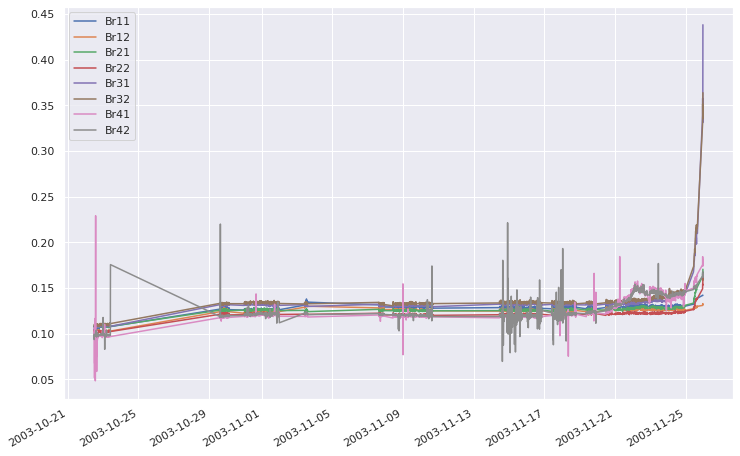

In [7]:
# plot all data
result_data.plot(figsize = (12,8));

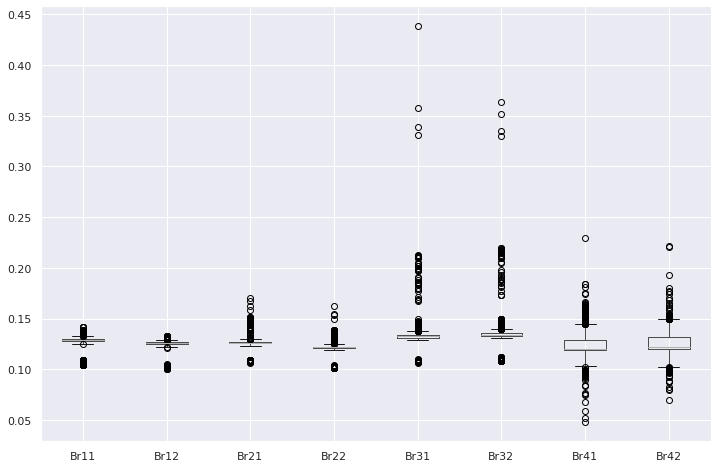

In [8]:
plt.figure(figsize = (12,8))

result_data.boxplot();

# dai boxplot si vede che almeno due sensori (3,4) ci sono tanti outliers

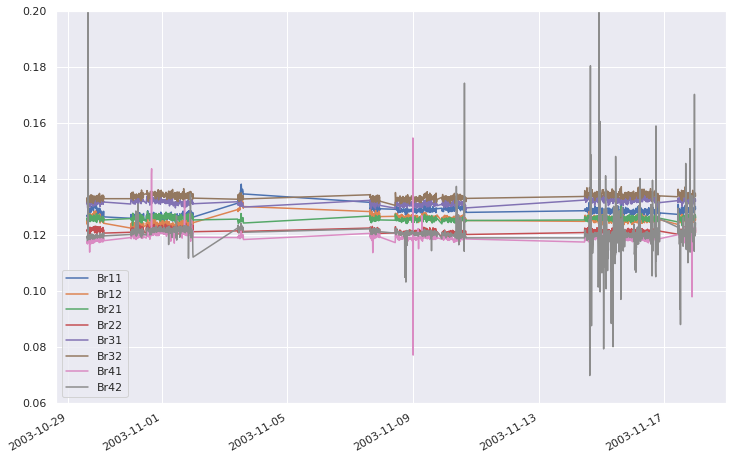

In [9]:
# sono Time Series quindi lo split train/test su base temporale

# data from the first interval used for training
dataset_train = result_data['2003-10-25 00:00:01':'2003-11-17 23:59:00']
dataset_test = result_data['2003-11-17 23:59:00':]

# these should be normal vibration
dataset_train.plot(figsize = (12,8), ylim = (0.06, 0.2));

# per interpretare bene il grafico che segue ricordiamo che c'è un buco nei dati dal 23/10 al 29/10

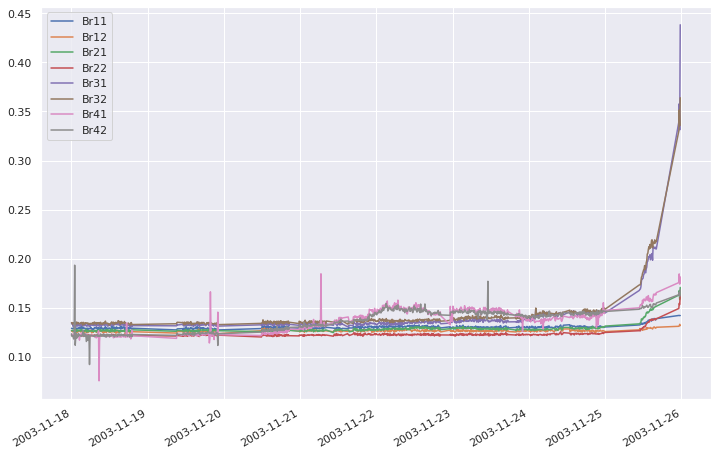

In [10]:
# then at a certain point in time vibration start to increase
# and those from some ball bearings "explode"
dataset_test.plot(figsize = (12,8));

### Data preparation and then training

In [11]:
# better to bring all features on the same scale
scaler = preprocessing.MinMaxScaler()

# scaler trained only on training set
X_train = pd.DataFrame(scaler.fit_transform(dataset_train), columns = dataset_train.columns, 
                       index = dataset_train.index)

# the same scaler applied to test set (no contamination)
X_test = pd.DataFrame(scaler.transform(dataset_test), columns = dataset_test.columns, 
                      index = dataset_test.index)

#### Define the Autoencoder (NN)

In [12]:
# define the NN
# 8 - 6 - 2 - 6 - 8

def get_model():
    input_num = X_train.shape[1]
    myreg = keras.regularizers.l1(10e-5)
    
    
    model = Sequential()
    
    # First hidden layer, connected to input vector X. 
    model.add(Dense(6, activation = "relu",
                # suggested from Chollet Blog on Autoencoders
                activity_regularizer = myreg,
                input_shape=(input_num,)
               )
         )
    
    model.add(Dense(2, activation = "relu", activity_regularizer = myreg))
    model.add(Dense(6, activation = "relu"))
    model.add(Dense(input_num))

    model.compile(loss='mse',optimizer='adam')
    
    return model

In [13]:
with strategy.scope():
    model = get_model()

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 6)                 54        
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 14        
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 18        
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 56        
Total params: 142
Trainable params: 142
Non-trainable params: 0
_________________________________________________________________


In [14]:
%%time

# Train the model (120 epochs)
NUM_EPOCHS = 120
BATCH_SIZE = 10
VAL_SPLIT = 0.1
VERBOSE = 0

X = np.array(X_train)

history = model.fit(X, X, batch_size = BATCH_SIZE, epochs = NUM_EPOCHS,
                    validation_split = VAL_SPLIT, verbose = VERBOSE)

CPU times: user 43.2 s, sys: 8.62 s, total: 51.9 s
Wall time: 24.5 s


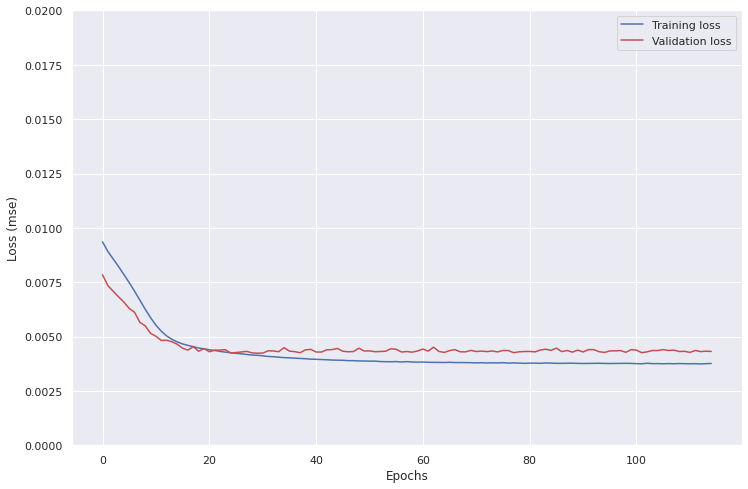

In [15]:
# visualize loss for the training (avoid first epochs to see improvements)
plt.figure(figsize = (12,8))
hist_loss = history.history['loss']
hist_val_loss = history.history['val_loss']

plt.plot(hist_loss[5:],'b', label='Training loss')
plt.plot(hist_val_loss[5:],'r', label='Validation loss')

plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Loss (mse)')
plt.ylim([0,.02])

plt.show()

In [16]:
# save the model
model.save('autoencoder1.h5')

/home/datascience/conda/tensorflow23_p37_gpu_v1/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(0.0, 0.16)

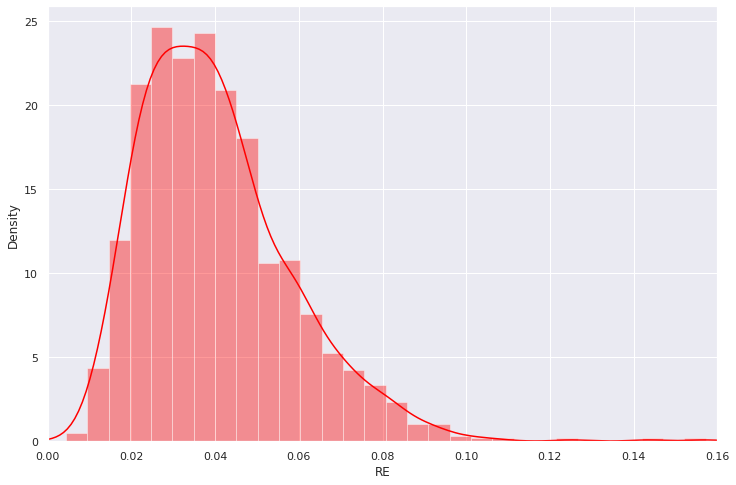

In [17]:
# prediction on train 
# RE: reconstruction error, calculated as MAE

# predict
X_pred = model.predict(np.array(X_train))

X_pred = pd.DataFrame(X_pred, columns=X_train.columns, index = X_train.index)

scored = pd.DataFrame(index = X_train.index)

# for every point compute the reconstruction error as MAE
# the mean of the abs of difference between real value and reconstructed value
scored['RE'] = np.mean(np.abs(X_pred - X_train), axis = 1)

plt.figure(figsize = (12,8))

# histogram
sns.distplot(scored['RE'], bins = 30, kde= True, color = 'red');

plt.xlim([0.0,.16])

In [18]:
# from plot above, we get threshold
THRESHOLD = 0.1

In [19]:
# compute prediction on TEST
X_pred = model.predict(np.array(X_test))
X_pred = pd.DataFrame(X_pred, columns = X_test.columns, index = X_test.index)

score = pd.DataFrame(index = X_test.index)
score['RE'] = round(np.mean(np.abs(X_pred - X_test), axis = 1), 4)

# threshold 0.1 (vedi grafico precedente)
score['Threshold'] = THRESHOLD
score['Anomaly'] = (score['RE'] > THRESHOLD)

# see predictions on last points (when the fault occurs)
score.tail(20)

,RE,Threshold,Anomaly
2003-11-25 13:37:32,1.6183,0.1,True
2003-11-25 13:47:32,1.7034,0.1,True
2003-11-25 13:57:32,1.6270,0.1,True
2003-11-25 14:07:32,1.6742,0.1,True
2003-11-25 14:17:32,1.5091,0.1,True
2003-11-25 14:27:32,1.6379,0.1,True
2003-11-25 14:37:32,1.7873,0.1,True
2003-11-25 14:47:32,1.7547,0.1,True
2003-11-25 14:57:32,1.5508,0.1,True
2003-11-25 15:07:32,1.7956,0.1,True


In [20]:
# final data all anomalous OK

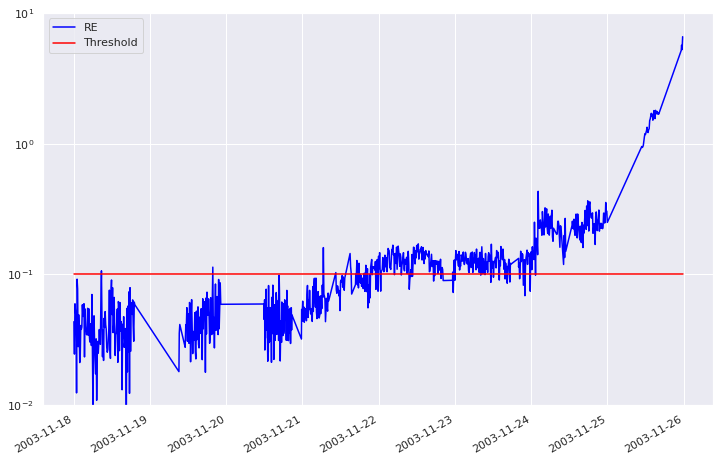

In [21]:
# plot with logaritmic scale y
score.plot(logy=True,  figsize = (12,8), ylim = [1e-2,1e1], color = ['blue','red']);

In [22]:
# from the plot we see that we could have been able to predict the fault in advance of 4-5 days!!!

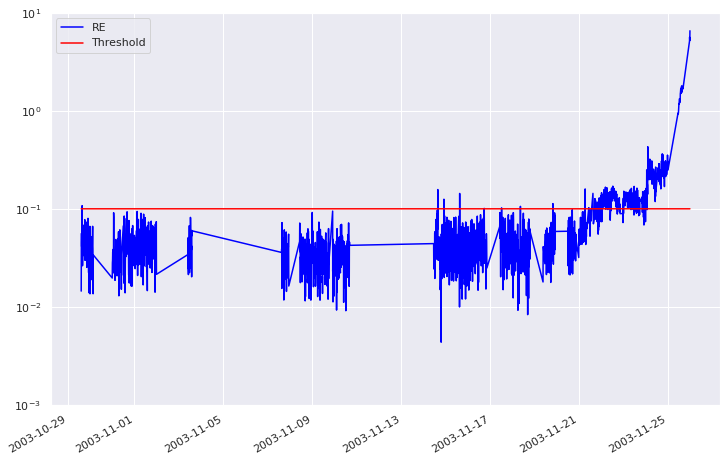

In [23]:
# have a look at training data to see if we have false positive
# i train data vanno fino al 17/11

X_pred_train = model.predict(np.array(X_train))
X_pred_train = pd.DataFrame(X_pred_train, columns = X_train.columns, index = X_train.index)

score_train = pd.DataFrame(index = X_train.index)
score_train['RE'] = np.mean(np.abs(X_pred_train-X_train), axis = 1)
score_train['Threshold'] = THRESHOLD
score_train['Anomaly'] = score_train['RE'] > THRESHOLD

# effettuo concatenazione dei due dataframe
score = pd.concat([score_train, score])

score.plot(logy=True,  figsize = (12,8), ylim = [1e-3,1e1], color = ['blue','red']);

quindi fino al 17/11 solo qualche rara segnalazione (RE > 0.1)

dal 21/11 in poi segnalazioni continue. OK

### Now we build the network with Functional API

In [24]:
# define the NN

seed(1234)
tf.random.set_seed(1234)

input_num = X_train.shape[1]
myreg = keras.regularizers.l1(10e-5)

input_vec = Input(shape=(input_num,))

# encoder
encoded = Dense(6, activation='relu', activity_regularizer = myreg)(input_vec)
encoded = Dense(2, activation='relu', activity_regularizer = myreg)(encoded)

# decoder
decoded = Dense(6, activation='relu')(encoded)
decoded = Dense(input_num)(decoded)

In [25]:
# the complete network
autoencoder = Model(input_vec, decoded)

In [26]:
# only the encoder
encoder = Model(input_vec, encoded)

In [27]:
autoencoder.compile(optimizer='adam', loss='mse')

In [28]:
autoencoder.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 8)]               0         
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 54        
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 14        
_________________________________________________________________
dense_6 (Dense)              (None, 6)                 18        
_________________________________________________________________
dense_7 (Dense)              (None, 8)                 56        
Total params: 142
Trainable params: 142
Non-trainable params: 0
_________________________________________________________________


In [29]:
history2 = autoencoder.fit(X, X, batch_size = BATCH_SIZE, epochs = NUM_EPOCHS,
                    validation_split = VAL_SPLIT, verbose = 0)

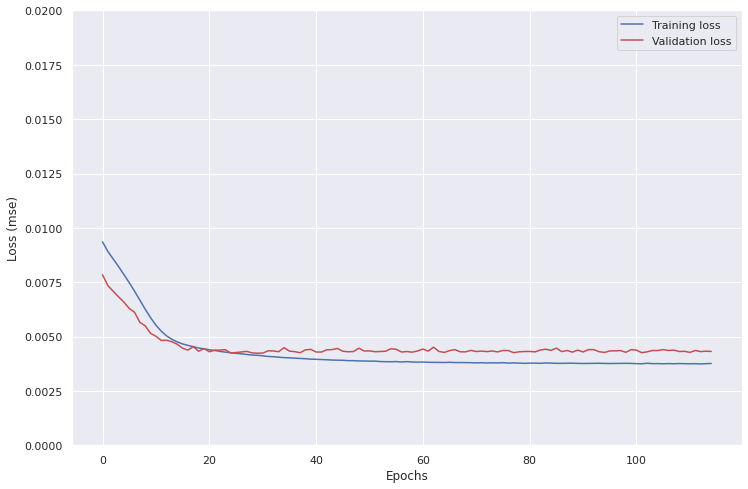

In [30]:
# visualizziamo la parte finale
plt.figure(figsize = (12,8))
hist_loss = history2.history['loss']
hist_val_loss = history2.history['val_loss']

plt.plot(hist_loss[5:],'b', label='Training loss')
plt.plot(hist_val_loss[5:],'r', label='Validation loss')

plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Loss (mse)')
plt.ylim([0,.02])

plt.show()

In [31]:
# obviously training is the same

In [32]:
# sul dataset di test la codifica (in 2 dim.)
# la parte di encoder trasforma il vettore in input (8 val) in una rappresentazione con due coordinate
# quindi la possiamo riportare su un piano x,y

# usiamo solo la parte di enconder
H_pred = encoder.predict(np.array(X_test))

H_pred = pd.DataFrame(H_pred, index = X_test.index)
H_pred['Anomaly'] = score['Anomaly']

In [33]:
H_pred

,0,1,Anomaly
2003-11-18 00:02:30,0.294194,0.481219,False
2003-11-18 00:12:30,0.305773,0.438733,False
2003-11-18 00:22:30,0.285483,0.338365,False
2003-11-18 00:32:30,0.233504,0.260975,False
2003-11-18 00:42:30,0.274822,0.386821,False
...,...,...,...
2003-11-25 16:07:32,1.225698,8.794664,True
2003-11-25 23:13:21,2.363754,20.203060,True
2003-11-25 23:19:56,2.547574,22.197617,True
2003-11-25 23:29:56,2.115971,19.898949,True


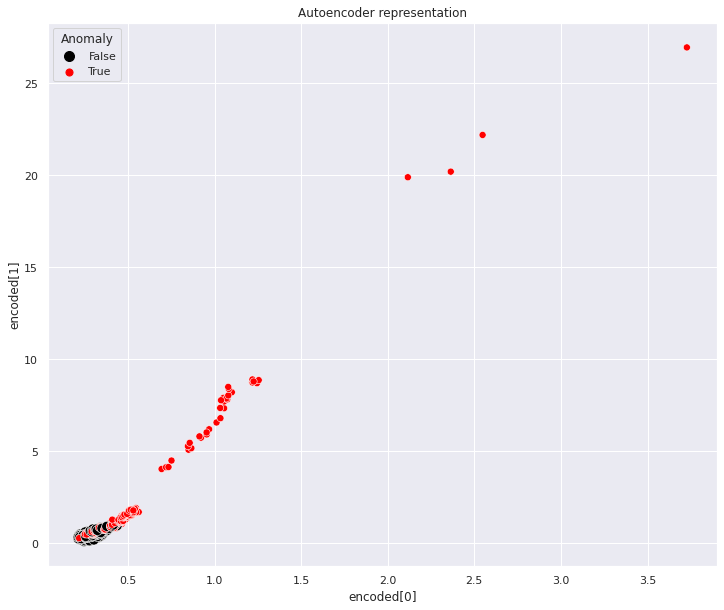

In [34]:
# scatter plot
# H_pred.plot.scatter(x = 0, y = 1, figsize = (12,8))
plt.figure(figsize = (12,10))

plt.xlabel('encoded[0]')
plt.ylabel('encoded[1]')
plt.title('Autoencoder representation')
sns.scatterplot(x= 0, y = 1, hue="Anomaly", size = "Anomaly", sizes = (50, 100), 
                data = H_pred, palette=['black','red'], legend='full');

In [35]:
# have a look at cluster near the origin
condition = ((H_pred[0] < 1) & (H_pred[1] < 4))

In [36]:
select = H_pred[condition]

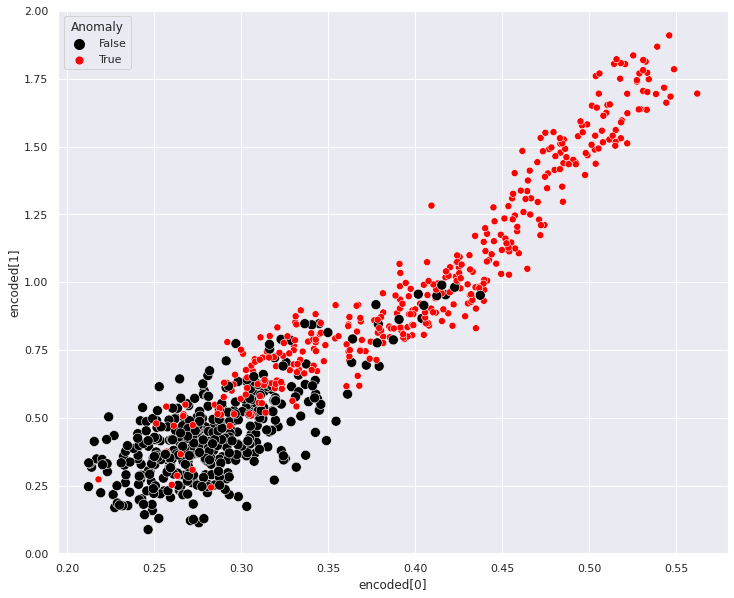

In [37]:
plt.figure(figsize = (12,10))

plt.xlabel('encoded[0]')
plt.ylabel('encoded[1]')

sns.scatterplot(x = 0, y = 1, hue="Anomaly", size = "Anomaly", sizes = (50, 100), 
                data = select, palette=['black','red'], legend='full');